# Notebook to create plots using the BIS data for credits to the non-financial sector

Data from: https://www.bis.org/statistics/about_credit_stats.htm?m=6%7C380

In [2]:
# Load libraries
library(BIS)
library(plyr)
library(dplyr)
library(lubridate)
library(zoo)
library(RColorBrewer)

# Creating a preferred color palette
co <- brewer.pal(7, "Set1")
co[6] <- "black"

Extracting the data from the API  
`get_bis` takes url as input and downloads and parses the corresponding CSV file from the BIS website

In [4]:
datasets <- get_datasets()
tc <- get_bis(datasets$url[datasets$name == "Credit to the non-financial sector"], quiet = TRUE)

Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  FREQ = col_character(),
  Frequency = col_character(),
  BORROWERS_CTY = col_character(),
  `Borrowers' country` = col_character(),
  TC_BORROWERS = col_character(),
  `Borrowing sector` = col_character(),
  TC_LENDERS = col_character(),
  `Lending sector` = col_character(),
  VALUATION = col_character(),
  Valuation = col_character(),
  UNIT_TYPE = col_character(),
  `Unit type` = col_character(),
  TC_ADJUST = col_character(),
  `Type of adjustment` = col_character(),
  `Time Period` = col_character()
)

See spec(...) for full column specifications.

Warning message:
“NAs introducidos por coerción”


The borrowing sector codes we will use are the following:
  1. General government
  2. Households & NPISHs
  3. Private non-financial sector
  4. Non-financial corporations
  5. Non-financial sector

Function that takes a country as input and the borrowing sector, lending sector, and time filters:

In [5]:
bis_data <- function(country, borrowing_sector = 1, lending_sector = 1, from = NA) {
  if(borrowing_sector==1) bor = "General government"
  if(borrowing_sector==2) bor = "Households & NPISHs"
  if(borrowing_sector==3) bor = "Private non-financial sector"  
  if(borrowing_sector==4) bor = "Non-financial corporations"
  if(borrowing_sector==5) bor = "Non financial sector"
  if(lending_sector==1) len = "A"
  if(lending_sector==2) len = "B"
  
  out <- tc %>% 
    filter(borrowers_country == country, valuation == "M", unit_type == "770", 
           tc_lenders == len, tc_adjust == "A", borrowing_sector == bor) %>%
    select(borrowers_country, borrowing_sector, lending_sector, 
           date, obs_value)
  out$date <- as.yearqtr(paste(substr(out$date,1,4), substr(out$date, 6, 7)))
  
  if (!is.na(from)) {
    out <- out %>% filter(date > as.yearqtr(from))
  }
  
  if (dim(out)[1] == 0) {
    return("No data")
  }
  return(out)
}

Plot function for a single and list of countries. Generates one plot for the specified type of borrowing / lending / time period:

In [6]:
plot_countries <- function(list_countries, borrowing_sector = 1, lending_sector = 1, from = NA){

  if (length(list_countries) == 1) {
    
    dt <- bis_data(list_countries, borrowing_sector = borrowing_sector, lending_sector = lending_sector, from = from)
    if (is.null(dim(dt))){
      return("No data")
    }
    plot(dt$date, dt$obs_value, main = paste(unique(dt$borrowing_sector), "\n",unique(dt$borrowers_country)), 
         type = "l", col = co[1], xlab = "Date", ylab = "% of GDP", sub = paste("Lender:", unique(dt$lending_sector)),
         xaxt = "n", las = 1, lwd = 2)
    axis(1)
  }
  
  else {
    
    # Check if all countries in the list have data
    check <- rep(NA, length(list_countries))
    
    for (i in 1:length(list_countries)) {
      tmp <- bis_data(list_countries[i], borrowing_sector = borrowing_sector, lending_sector = lending_sector, from = from)
      if (!is.null(dim(tmp))) {
        check[i] <- TRUE
      } else {
        check[i] <- FALSE
      }
    }
    
    countries <- list_countries[check]
    
    for (i in 1:length(countries)){
      if (i == 1){
        out <- bis_data(countries[1], borrowing_sector = borrowing_sector, lending_sector = lending_sector, from = from)
        bor <- unique(out$borrowing_sector)
        len <- unique(out$lending_sector)
        out <- out[, c("date", "obs_value")]
        names(out)[2] <- countries[1]
      } else {
        tmp <- bis_data(countries[i], borrowing_sector = borrowing_sector, lending_sector = lending_sector, from = from)
        tmp <- tmp[, c("date", "obs_value")]
        names(tmp)[2] <- countries[i]
        out <- join(out, tmp, by = c("date"))
      }
    }
    leg <- rep(NA, length(countries))
    for (i in 1:length(countries)){
      leg[i] <- unique(tc[tc$borrowers_country == countries[i], c("borrowers_cty")])
    }
    
    matplot(out$date, out[, countries], type = "l", lty = 1, col = co[1:length(countries)],
            main = bor, sub = paste("Lender:",len), xlab = "Date", ylab = "% of GDP", las = 1, lwd = 2
              )
    legend("top", inset = c(0,-0.1), legend = leg, xpd = TRUE, 
          col = co, lty = 1, bty = "n", lwd = 2, cex = 0.8, ncol = length(countries), horiz = F,
          text.width = 2)
    }

}

Function that creates a set of plots for a single borrower country where each subplot is a borrowing sector:

In [7]:
allplots <- function(country, lending_sector = 1, from = NA){
  
  borrow <- seq(5)
  check <- rep(NA, 5)
  for (i in borrow){
    tmp <- bis_data(country, borrowing_sector = i, lending_sector = lending_sector, from = from)
    if (!is.null(dim(tmp))) {
      check[i] <- TRUE
    } else {
      check[i] <- FALSE
    }
  }
  borrow <- borrow[check]
  
  par(mfrow = c(length(borrow),1), mai = c(0.3, 0.6, 0.2, 0.1))
  
  for (i in borrow){
    dt <- bis_data(country, borrowing_sector = i, lending_sector = lending_sector, from = from)
    plot(dt$date, dt$obs_value, main = paste(unique(dt$borrowing_sector), " - ",unique(dt$borrowers_country)), 
        type = "l", col = co[i], xlab = "Date", ylab = "% of GDP", sub = paste("Lender:", unique(dt$lending_sector)),
        xaxt = "n", las = 1, lwd = 2)
    axis(1)
  }
  par(mfrow = c(1,1), mar = c(0,0,0,0))
}

## Sample plots

#### Plots with single country

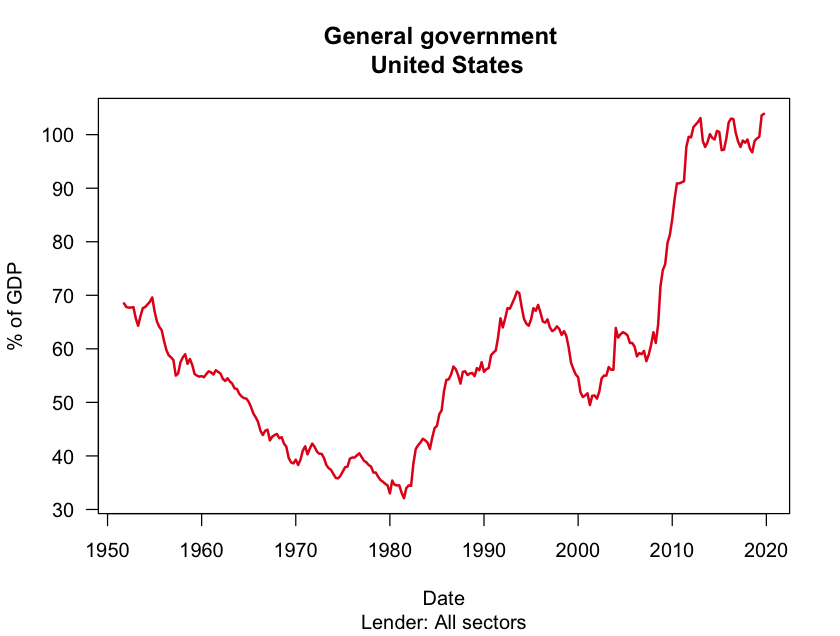

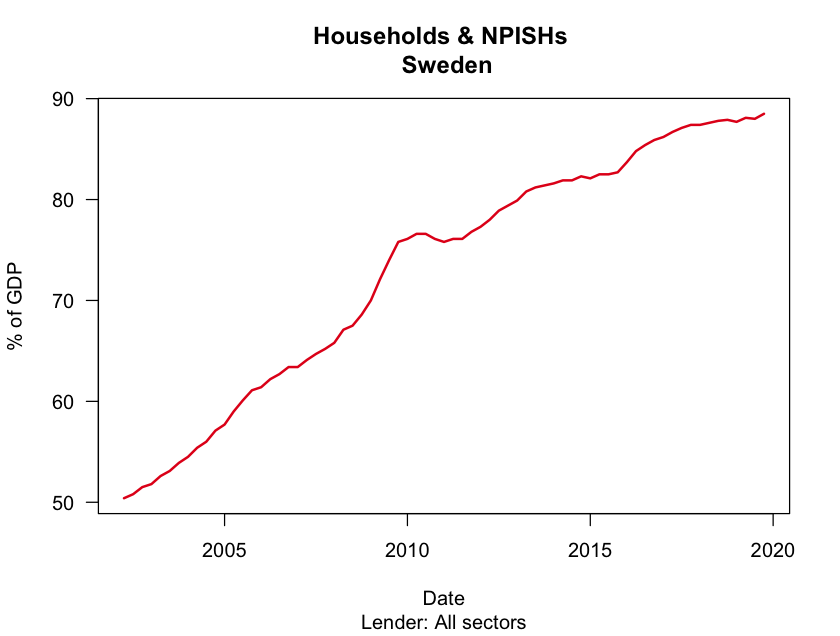

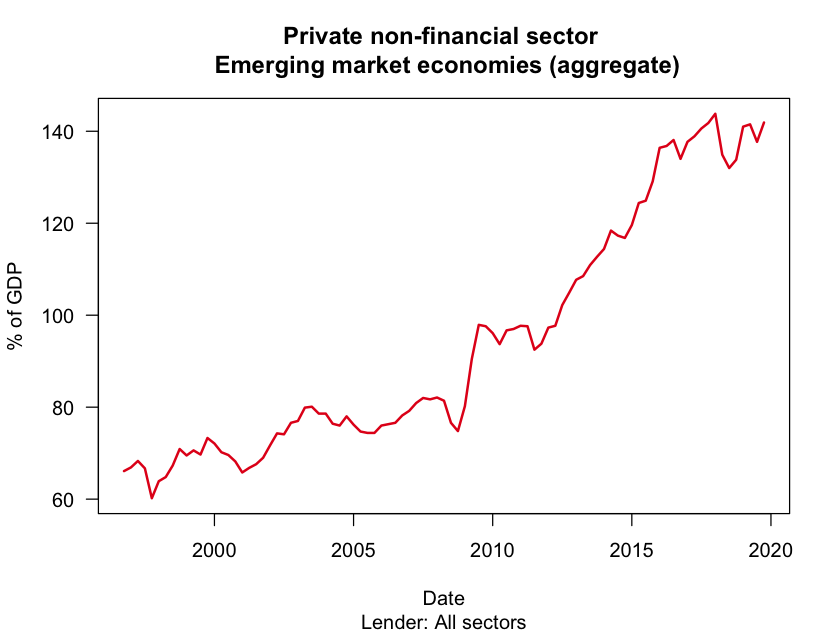

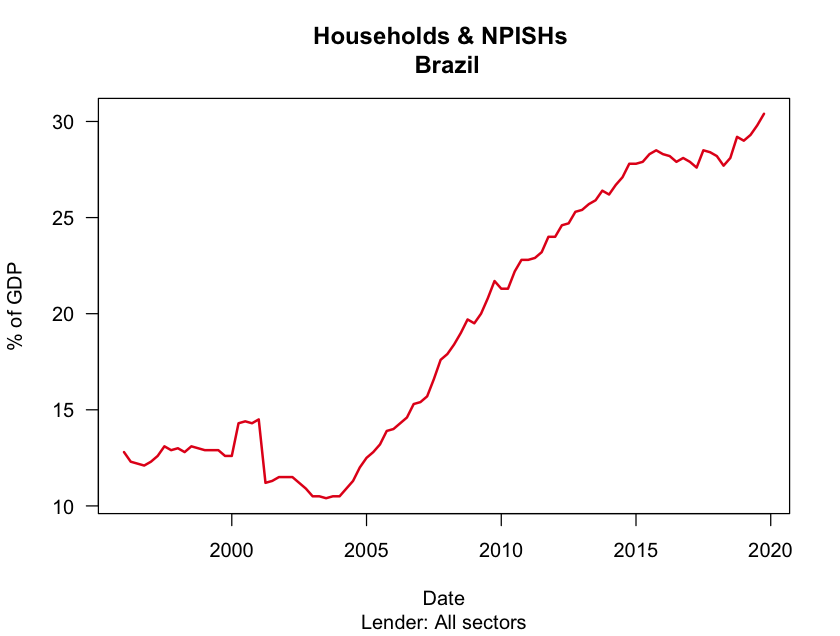

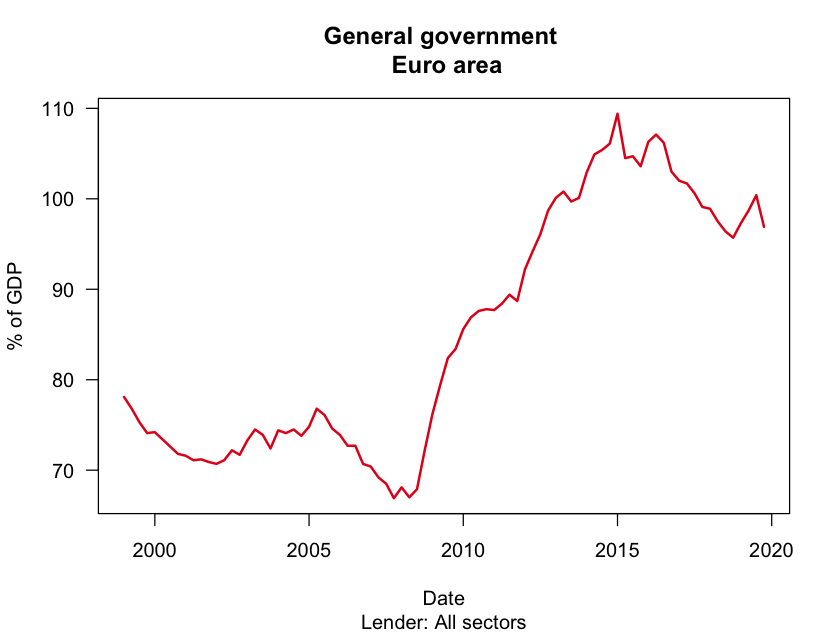

In [12]:
options(repr.plot.width=7, repr.plot.height=5.3)
plot_countries("United States", borrowing_sector = 1)
plot_countries("Sweden", borrowing_sector = 2, from = 2002)
plot_countries("Emerging market economies (aggregate)", borrowing_sector = 3)
plot_countries("Brazil", borrowing_sector = 2, lending_sector = 1)
plot_countries("Euro area", 1)

### Plots comparing countries

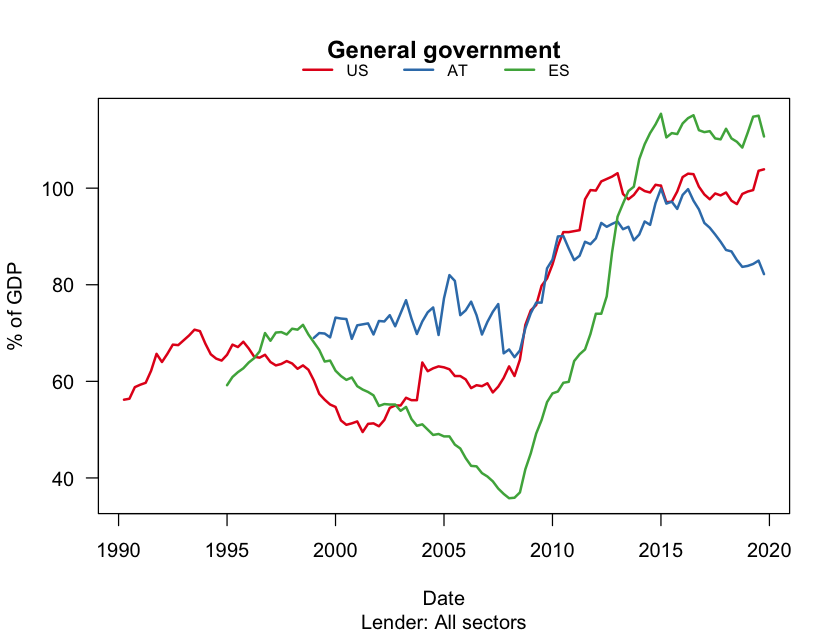

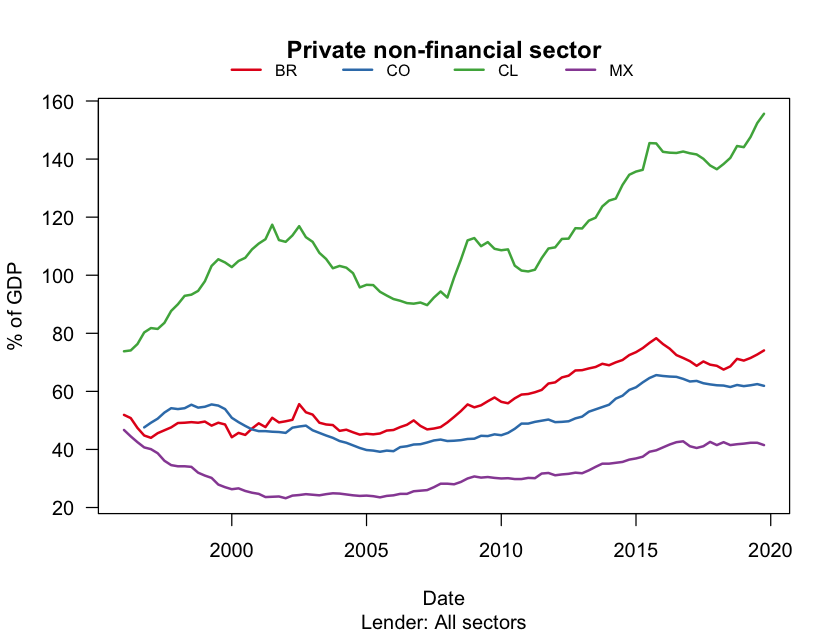

In [11]:
options(repr.plot.width=7, repr.plot.height=5.3)
plot_countries(c("United States", "Austria", "Spain"), 1, from = 1990)
plot_countries(c("Brazil", "Colombia", "Chile", "Mexico"), 3)

### All plots for a single country

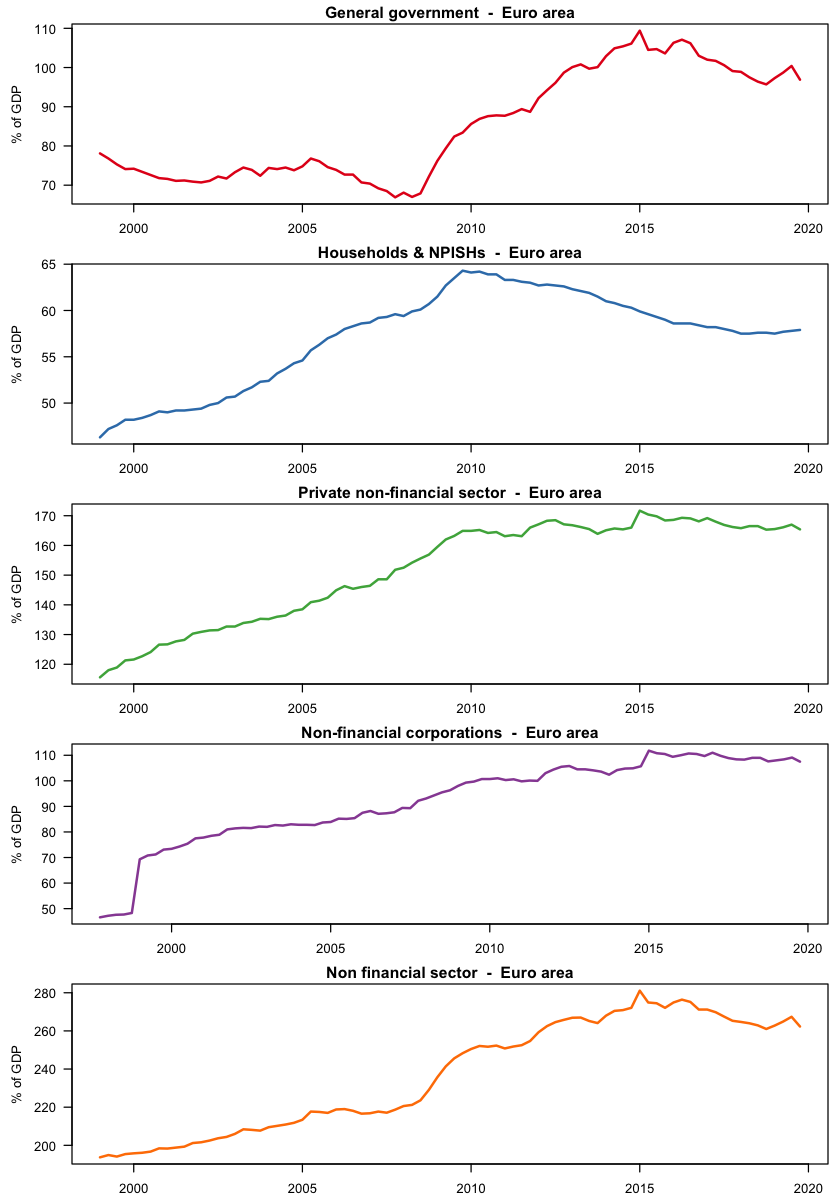

In [16]:
options(repr.plot.width=7, repr.plot.height=10)
allplots("Euro area")

### Saving some plots as vectors

In [18]:
list_countries <- c("Brazil","Spain","France","United Kingdom","Ireland","United States")

postscript("households.eps", height = 5.3, width = 7)
plot_countries(list_countries, 2)

postscript("government.eps", height = 5.3, width = 7)
plot_countries(list_countries, 1)

postscript("private_nonfin.eps", height = 5.3, width = 7)
plot_countries(list_countries, 3)

postscript("nonfin_corp.eps", height = 5.3, width = 7)
plot_countries(list_countries, 4)

postscript("nonfin.eps", height = 5.3, width = 7)
plot_countries(list_countries, 5)

postscript("emerging.eps", height = 5.3, width = 7)
allplots("Emerging market economies (aggregate)")

postscript("advanced.eps", height = 5.3, width = 7)
allplots("Advanced economies")

postscript("all_economies.eps", height = 5.3, width = 7)
allplots("All reporting economies")

postscript("g20.eps", height = 5.3, width = 7)
allplots("G20 economies")